In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to parse each log line
def parse_log_line(line):
    parts = line.strip().split()
    if not parts:
        return None
    # The first two tokens are the date and time
    timestamp = parts[0] + " " + parts[1]
    data = {"timestamp": timestamp}
    
    # Process remaining tokens that are in key=value format
    for token in parts[2:]:
        if '=' in token:
            key, value = token.split('=', 1)
            # Remove trailing 'ms' and convert to float for latency fields
            if key in ['avg_latency', 'min_latency', 'max_latency']:
                if value.endswith('ms'):
                    value = value[:-2]
                try:
                    value = float(value)
                except ValueError:
                    pass
            # Convert numeric fields to int
            elif key in ['total_samples', 'success_count', 'fail_count', 'port']:
                try:
                    value = int(value)
                except ValueError:
                    pass
            # For the samples field, split by semicolon and convert each to float
            elif key == 'samples':
                try:
                    value = [float(x) for x in value.split(';') if x]
                except ValueError:
                    value = []
            # For other keys (like host or source), keep as string
            data[key] = value
    return data

# Read and parse the log file
log_entries = []
with open('latency.log', 'r') as f:
    for line in f:
        if line.strip():
            entry = parse_log_line(line)
            if entry:
                log_entries.append(entry)

# Create a DataFrame from the parsed log entries
df = pd.DataFrame(log_entries)

# Convert the timestamp column to datetime objects and sort the DataFrame
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values('timestamp', inplace=True)

# Display the first few rows of the DataFrame
df.head()

hosts = df['host'].unique()
sources = df['source'].unique()

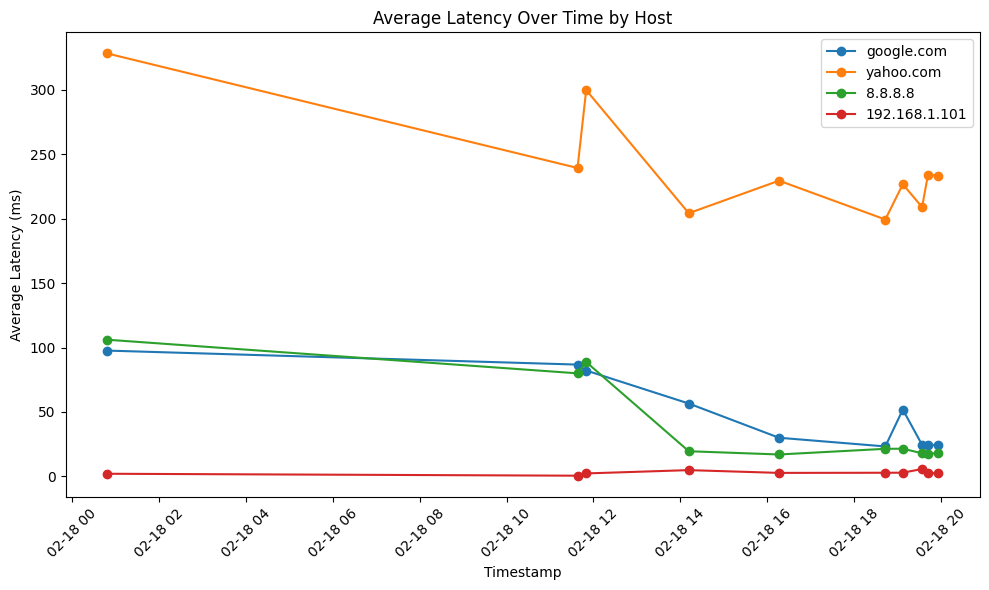

In [50]:

# Plot average latency over time for each host
plt.figure(figsize=(10, 6))

for host in hosts:
    host_df = df[df['host'] == host]
    plt.plot(host_df['timestamp'], host_df['avg_latency'], marker='o', label=host)

plt.xlabel('Timestamp')
plt.ylabel('Average Latency (ms)')
plt.title('Average Latency Over Time by Host')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


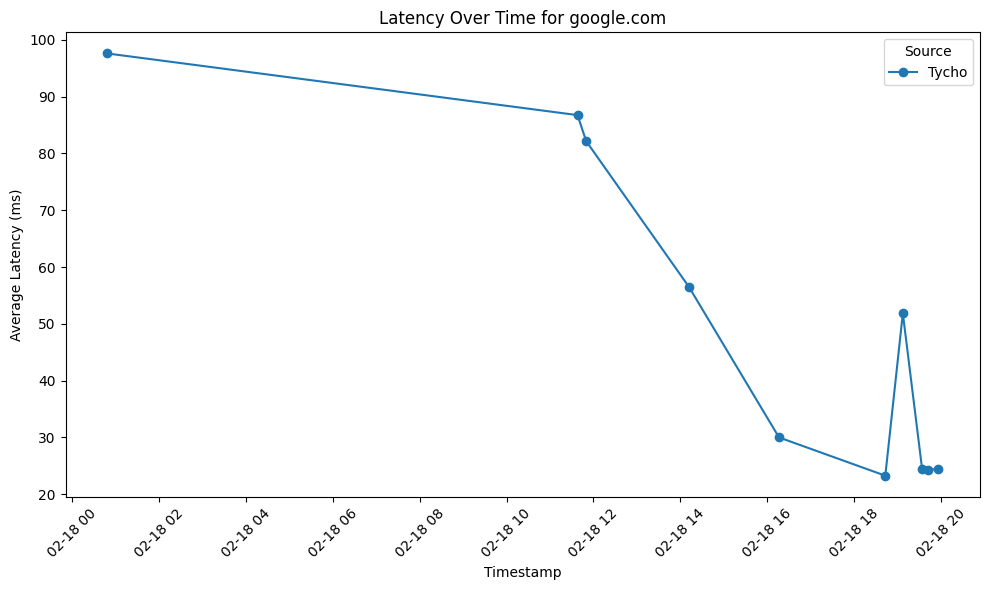

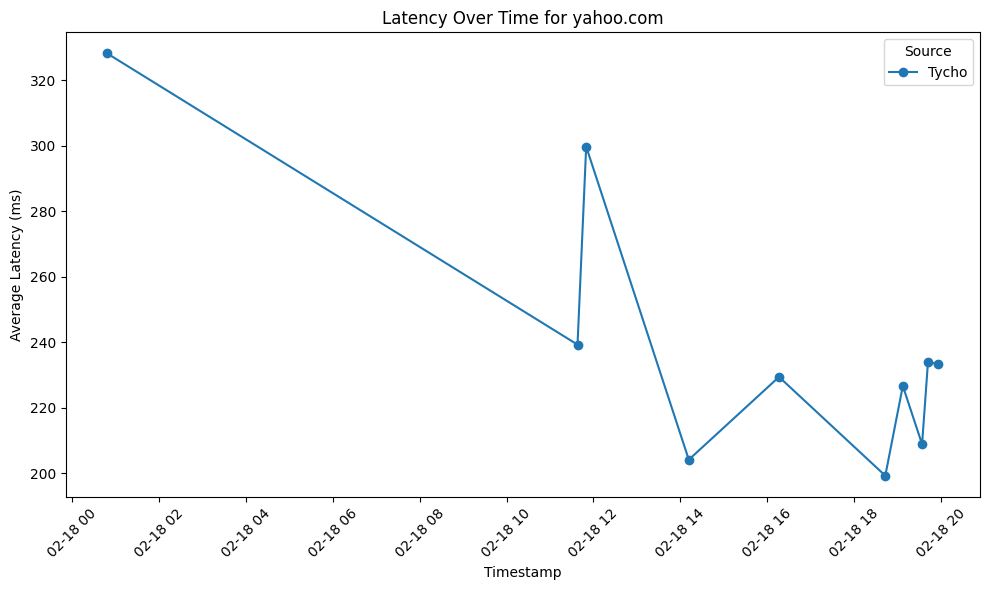

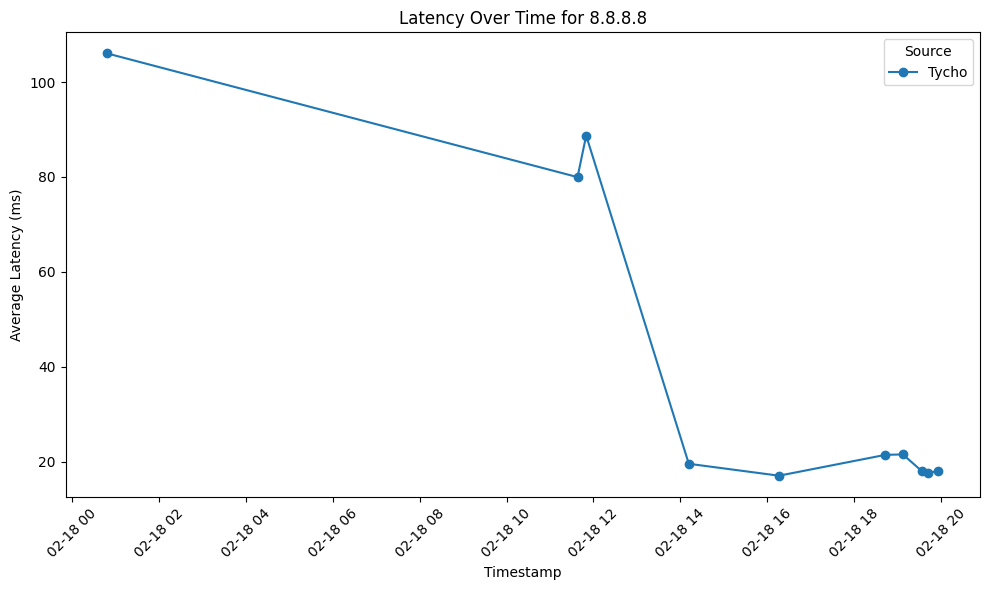

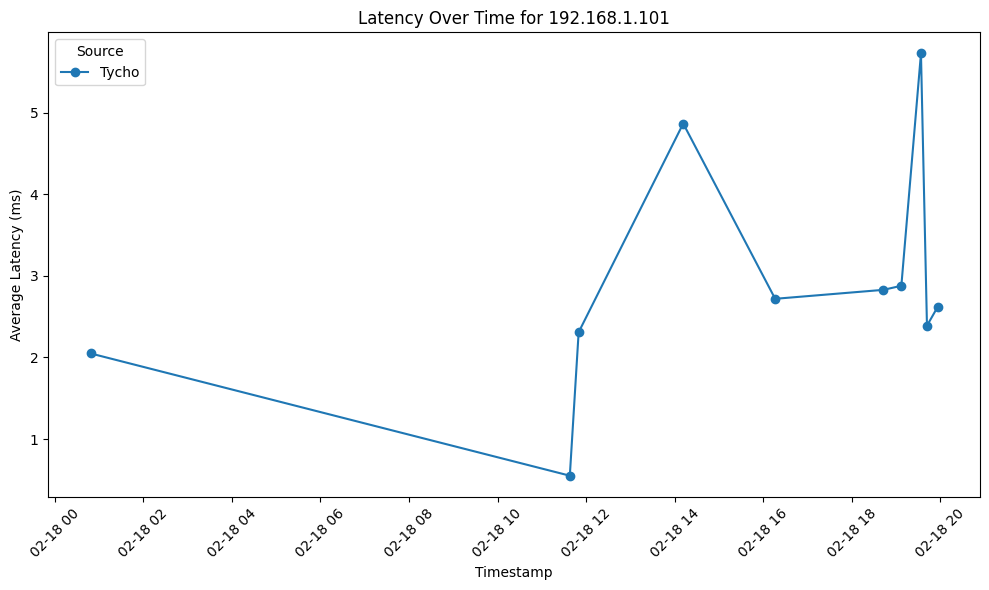

In [51]:
for host in hosts:
    # Filter the DataFrame for the current host
    host_df = df[df['host'] == host]
    
    plt.figure(figsize=(10, 6))
    
    # Plot average latency for each source for this host
    for source in host_df['source'].unique():
        source_df = host_df[host_df['source'] == source]
        plt.plot(source_df['timestamp'], source_df['avg_latency'], marker='o', label=source)
    
    plt.title(f"Latency Over Time for {host}")
    plt.xlabel("Timestamp")
    plt.ylabel("Average Latency (ms)")
    plt.xticks(rotation=45)
    plt.legend(title="Source")
    plt.tight_layout()
    plt.show()

# Candle charts

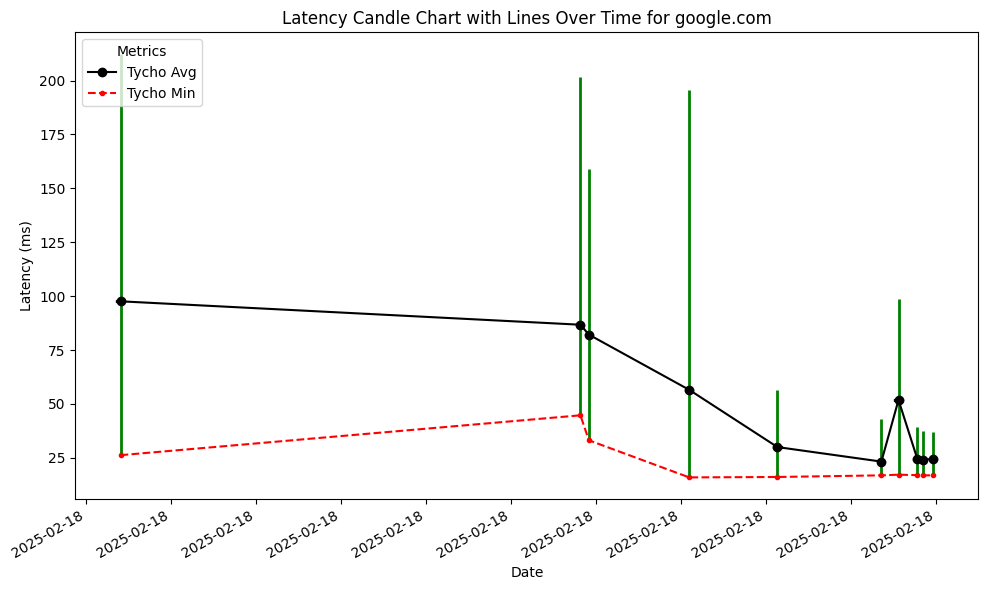

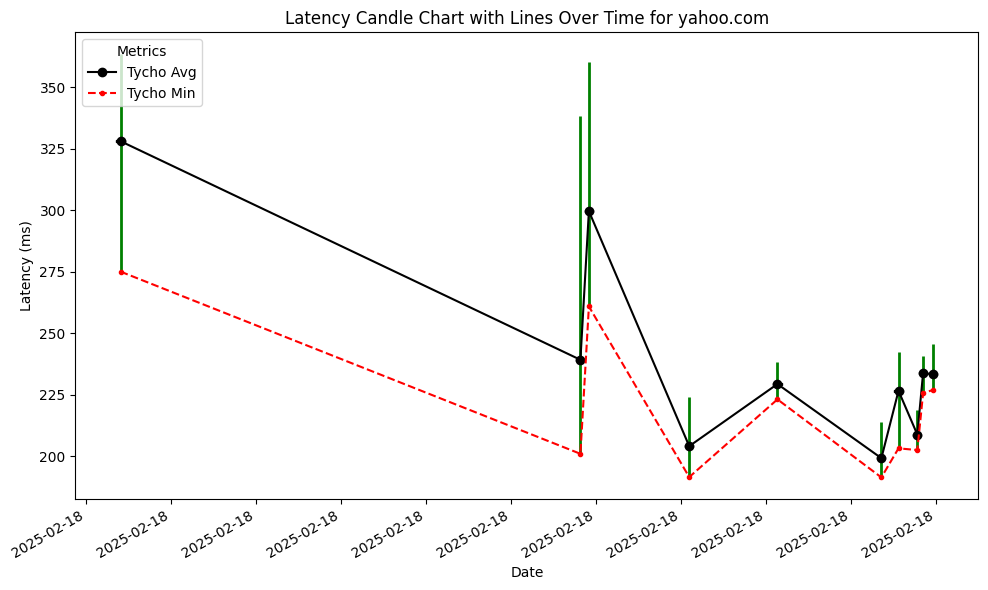

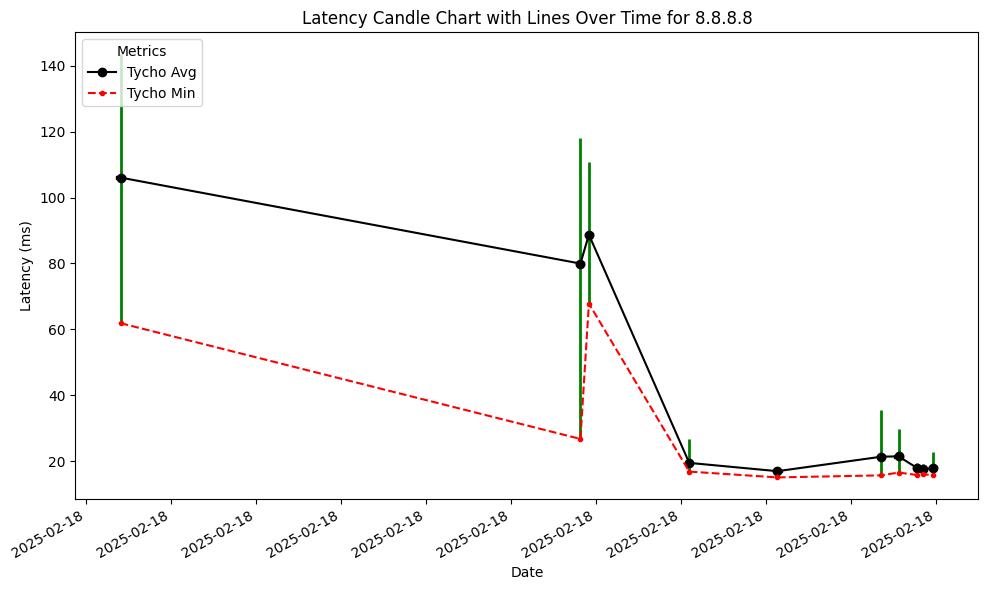

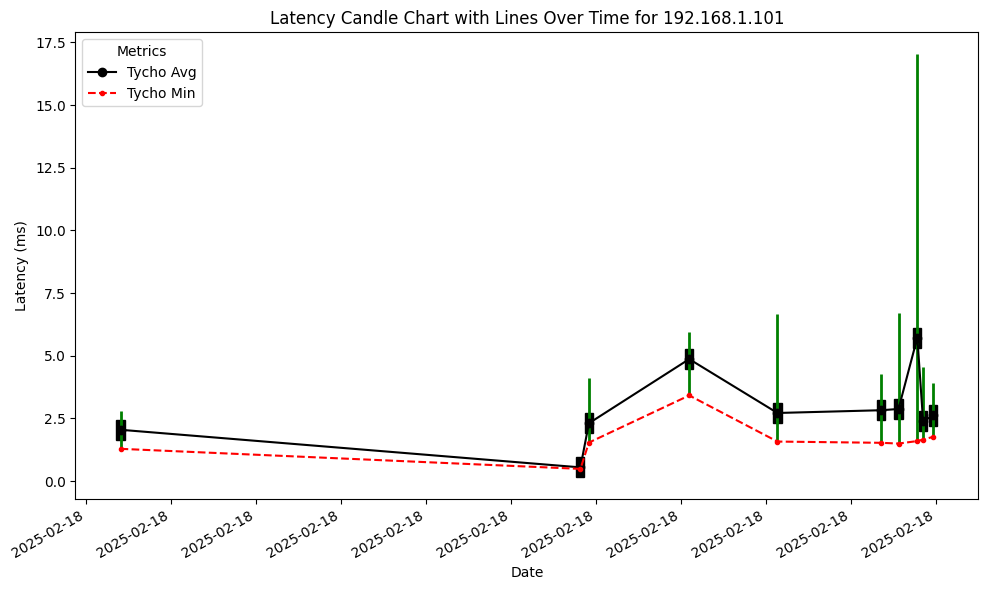

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches


# Get the list of unique hosts
hosts = df['host'].unique()

for host in hosts:
    host_df = df[df['host'] == host]
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # To build a custom legend later
    legend_handles = []
    
    # Loop through each source (e.g., Tycho, ca2e18034435)
    for i, source in enumerate(host_df['source'].unique()):
        source_df = host_df[host_df['source'] == source]
        
        body_color = 'black'
        wick_color = 'green'
        
        
        # Apply a small offset for this source to avoid overlap on the x-axis
        offset = i * 0.005
        
        # Lists to store x positions and metric values for line plotting
        xs = []
        avg_vals = []
        min_vals = []
        max_vals = []
        
        # Loop through each data point in this source's DataFrame
        for ts, avg, min_val, max_val in zip(source_df['timestamp'],
                                             source_df['avg_latency'],
                                             source_df['min_latency'],
                                             source_df['max_latency']):
            x = mdates.date2num(ts) + offset
            xs.append(x)
            avg_vals.append(avg)
            min_vals.append(min_val)
            max_vals.append(max_val)
            
            # Draw the wick (vertical line from min to max) with the specified wick color
            ax.vlines(x, min_val, max_val, color=wick_color, linewidth=2)
            
            # Draw the body (a small rectangle centered at the average value)
            candle_width = 0.008
            candle_height = 0.8  # adjust for desired visual thickness
            rect = plt.Rectangle((x - candle_width/2, avg - candle_height/2),
                                 candle_width, candle_height,
                                 facecolor=body_color, edgecolor=body_color)
            ax.add_patch(rect)
        
        # Plot a line connecting the average values (solid line)
        ax.plot(xs, avg_vals, color=body_color, linestyle='-', marker='o', label=f"{source} Avg")
        # Plot a line connecting the min values (dashed line)
        # ax.plot(xs, min_vals, color='red', linestyle='--', marker='.', label=f"{source} Min")
        # Plot a line connecting the max values (dashed line)
        # ax.plot(xs, max_vals, color='blue', linestyle='--', marker='.', label=f"{source} Max")
        
        # Create a legend patch for the source (using the body color)
        patch = mpatches.Patch(color=body_color, label=source)
        legend_handles.append(patch)
    
    # Format the x-axis to display dates
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    
    plt.title(f"Latency Candle Chart with Lines Over Time for {host}")
    plt.xlabel("Date")
    plt.ylabel("Latency (ms)")
    plt.legend(title="Metrics", loc='upper left')
    plt.tight_layout()
    plt.show()


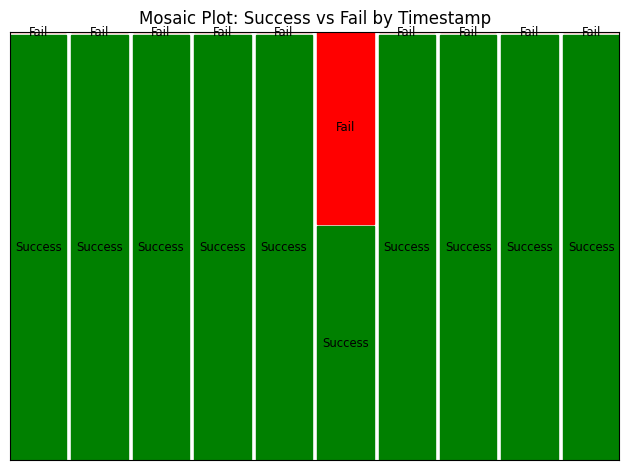

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Ensure the 'timestamp' column is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group by timestamp and aggregate success and fail counts
grouped = df.groupby('timestamp').agg({'success_count': 'sum', 'fail_count': 'sum'}).reset_index()

# Build a dictionary for the mosaic plot.
# Keys are (timestamp_string, category) tuples.
data = {}
for _, row in grouped.iterrows():
    ts_str = row['timestamp'].strftime("%Y-%m-%d %H:%M:%S")
    data[(ts_str, 'Success')] = row['success_count']
    data[(ts_str, 'Fail')] = row['fail_count']

# Create the mosaic plot.
fig, _ = mosaic(data, title="Mosaic Plot: Success vs Fail by Timestamp", gap=0.009,
                properties=lambda key: {'color': 'g' if key[1] == 'Success' else 'r'},
                labelizer=lambda key: key[1],
                axes_label=False)
# Get the current axes
plt.tight_layout()
plt.show()

